# Dequantization

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

sys.path.insert(1, '../src/')
import concrete
import gibbs
from discrete_mixflows import elbo_exact

plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams["figure.figsize"]=15,7.5
plt.rcParams.update({'font.size': 40})

## 1D toy problem

In [2]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=10
prbs=np.random.rand(K1)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (1,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K1) array with d conditionals 
    
    ext_lprb=np.log(np.repeat(prbs[:,np.newaxis],x.shape[1],axis=1).T)
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x])
    return ext_lprb
prbs_onedim=np.copy(prbs)

In [3]:
########################
########################
#    Gibbs sampling    #
########################
########################

np.random.seed(2023)
gibbs_ss=5000
x0=np.random.randint(low=0,high=K1)*np.ones(1)

gibbs_samples_onedim=gibbs.gibbs_sampler(x0=x0,steps=gibbs_ss,lp=lp,burnin_pct=0.25,verbose=True) #(K1,gibbs_ss)

In [4]:
def create_dequant_RealNVP(dim,depth,width):
    """
    Wrapper to init a RealNVP flow for a dequantization problem
    with dimension dim that consists of depth layers

    The reference distribution is an isotropic Gaussian

    Inputs:
        dim   : int, dimension of data
        depth : int, number of couplings (transformations)
        width : int, width of the linear layers

    Outputs:
        flow   : Module, RealNVP
    """

    # create channel-wise masks of appropriate size
    masks=torch.zeros((2,dim))
    masks[0,:(dim//2)]=1
    masks[1,(dim-(dim//2)):]=1
    masks=masks.repeat(depth//2,1)

    # define reference distribution
    ref = torch.distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))

    # define scale and translation architectures
    net_s = lambda: nn.Sequential(
        nn.Linear(dim, width),
        nn.LeakyReLU(),
        nn.Linear(width, width),
        nn.LeakyReLU(),
        nn.Linear(width, dim),
        nn.Tanh()
    )
    net_t = lambda: nn.Sequential(
        nn.Linear(dim, width),
        nn.LeakyReLU(),
        nn.Linear(width, width),
        nn.LeakyReLU(),
        nn.Linear(width, dim)
    )
    return concrete.RealNVP(net_s, net_t, masks, ref)

In [5]:
def train_dequant_discrete(depth,sample,width=32,max_iters=1000,lr=1e-4,seed=0,verbose=True):
    """
    Train a dequantized RealNVP normalizing flow using the Adam optimizer

    Input:
        depth     : int, number of couplings (transformations)
        sample    : (dim,B) array, quantized sample from target (e.g., from Gibbs sampler)
        width     : int, width of the linear layers
        max_iters : int, max number of Adam iters
        lr        : float, Adam learning rate
        
        seed      : int, for reproducibility
        verbose   : boolean, indicating whether to print loss every 100 iterations of Adam
    """
    torch.manual_seed(seed)

    # create flow
    dim,B = sample.shape
    flow = create_dequant_RealNVP(dim,depth,width)

    # dequantize sample
    training_sample = torch.from_numpy(sample.T) + torch.rand(B,dim)
    
    # train flow
    optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr)
    losses=np.zeros(max_iters)

    for t in range(max_iters):
        loss = -flow.log_prob(training_sample).mean()
        losses[t]=loss

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if verbose and t%(max_iters//10) == 0: print('iter %s:' % t, 'loss = %.3f' % loss)
    # end for
    return flow,losses

In [6]:
########################
########################
#    dequantization    #
########################
########################

# settings
depth = 10
sample = np.copy(gibbs_samples_onedim)
width = 32
max_iters = 1001
lr = 1e-4

flow_onedim,loss_onedim=train_dequant_discrete(depth,sample,width,max_iters,lr)

iter 0: loss = 62.843
iter 100: loss = 7.199
iter 200: loss = 3.679
iter 300: loss = 2.998
iter 400: loss = 2.807
iter 500: loss = 2.718
iter 600: loss = 2.657
iter 700: loss = 2.619
iter 800: loss = 2.598
iter 900: loss = 2.587
iter 1000: loss = 2.582


In [7]:
dequant_samples = np.squeeze(flow_onedim.sample(10000).detach().numpy())
dequant_samples = np.floor(dequant_samples).astype(int) # round to get sample
dequant_density_onedim = plt.hist(dequant_samples,density=True,bins=np.arange(0,K1+1))[0];
plt.clf()

<Figure size 1500x750 with 0 Axes>

(0.0, 0.25)

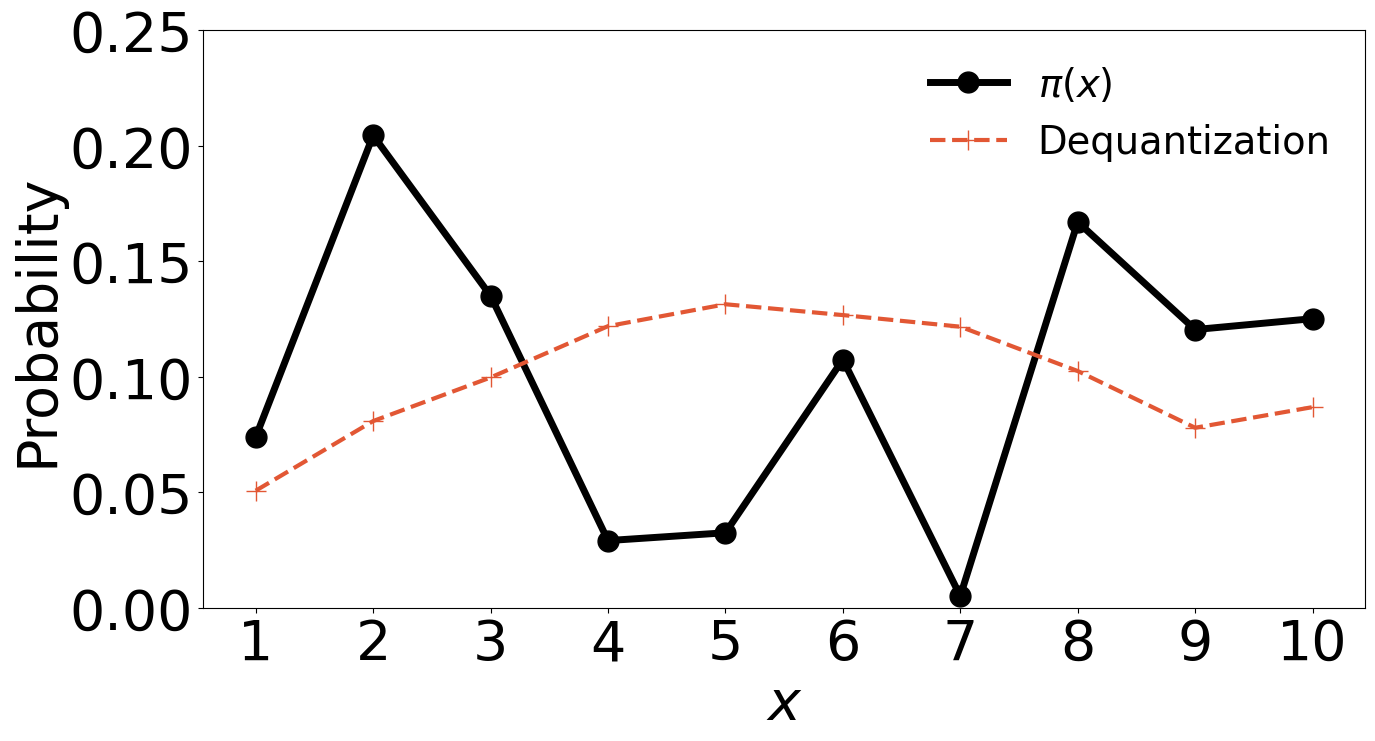

In [8]:
########################
########################
#     plot results     #
########################
########################

ttx=np.arange(0,10)
plt.plot(ttx+0.5,prbs_onedim,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.plot(ttx+0.5,dequant_density_onedim,c='#E25734', label='Dequantization',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='x-small',frameon=False)
plt.xlabel(r'$x$')
plt.xticks(ticks=np.arange(0,10)+0.5,labels=np.arange(1,1+10))
plt.ylabel('Probability')
plt.ylim(0,0.25)

In [9]:
elbo_exact(np.log(dequant_density_onedim),np.log(prbs_onedim))

-0.5257751289734226

## 2D example

In [10]:
########################
########################
# target specification #
########################
########################
np.random.seed(2023)
K1=4
K2=5
prbs=np.random.rand(K1,K2)
prbs=prbs/np.sum(prbs)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    ext_lprb=np.log(np.moveaxis(np.repeat(prbs[:,:,np.newaxis],x.shape[1],axis=-1),2,0)) # stack d copies of logp vertically
    if axis==None: return np.squeeze(ext_lprb[np.arange(0,x.shape[1]),x[0,:],x[1,:]]) # for each d, return lp(x)
    if axis==0: return ext_lprb[np.arange(0,x.shape[1]),:,x[1,:]]
    if axis==1: return ext_lprb[np.arange(0,x.shape[1]),x[0,:],:]
    raise Exception("Axis out of bounds - there aren't that many variables")
prbs_twodim=np.copy(prbs)

In [11]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
gibbs_ss=5000
x0=np.array([np.random.randint(low=0,high=K1),np.random.randint(low=0,high=K2)])

gibbs_samples_twodim=gibbs.gibbs_sampler(x0=x0,steps=gibbs_ss,lp=lp,burnin_pct=0.25,verbose=True)

In [12]:
########################
########################
#    dequantization    #
########################
########################

# settings
depth = 10
sample = np.copy(gibbs_samples_twodim)
width = 32
max_iters = 1001
lr = 1e-4

flow_twodim,loss_twodim=train_dequant_discrete(depth,sample,width,max_iters,lr)

iter 0: loss = 7.184
iter 100: loss = 3.738
iter 200: loss = 3.322
iter 300: loss = 3.190
iter 400: loss = 3.155
iter 500: loss = 3.134
iter 600: loss = 3.110
iter 700: loss = 3.085
iter 800: loss = 3.058
iter 900: loss = 3.028
iter 1000: loss = 2.998


In [13]:
dequant_samples = np.squeeze(flow_twodim.sample(10000).detach().numpy())
dequant_samples = np.floor(dequant_samples).astype(int) # round to get sample
dequant_density_twodim = plt.hist2d(dequant_samples[:,0],dequant_samples[:,1],density=True,
                         bins=[np.arange(0,K1+1),np.arange(0,K2+1)])[0]
plt.clf()

<Figure size 1500x750 with 0 Axes>

([<matplotlib.axis.XTick at 0x17ff54040>,
 [Text(0.5, 0, '1'), Text(1.5, 0, '2'), Text(2.5, 0, '3'), Text(3.5, 0, '4')])

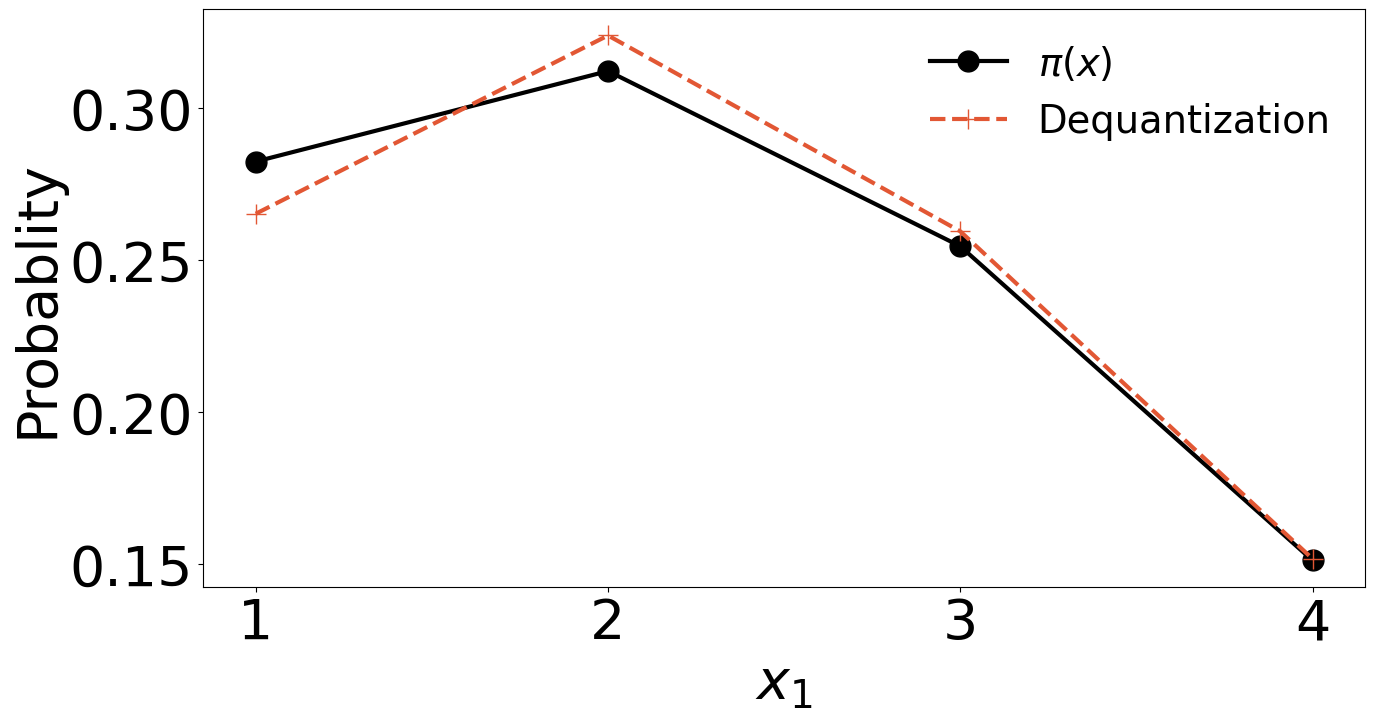

In [14]:
########################
########################
#   plot x1 results    #
########################
########################

ttx=np.arange(0,4)
plt.plot(ttx+0.5,np.sum(prbs_twodim,axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(dequant_density_twodim,axis=1),c='#E25734', label='Dequantization',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='x-small',frameon=False)
plt.xlabel(r'$x_1$')
plt.ylabel('Probablity')
plt.xticks(ticks=np.arange(0,4)+0.5,labels=np.arange(1,1+4))
#plt.savefig(fig_path+'twodim_prbs1.pdf', dpi=300, bbox_inches='tight')

Text(0, 0.5, 'Probability')

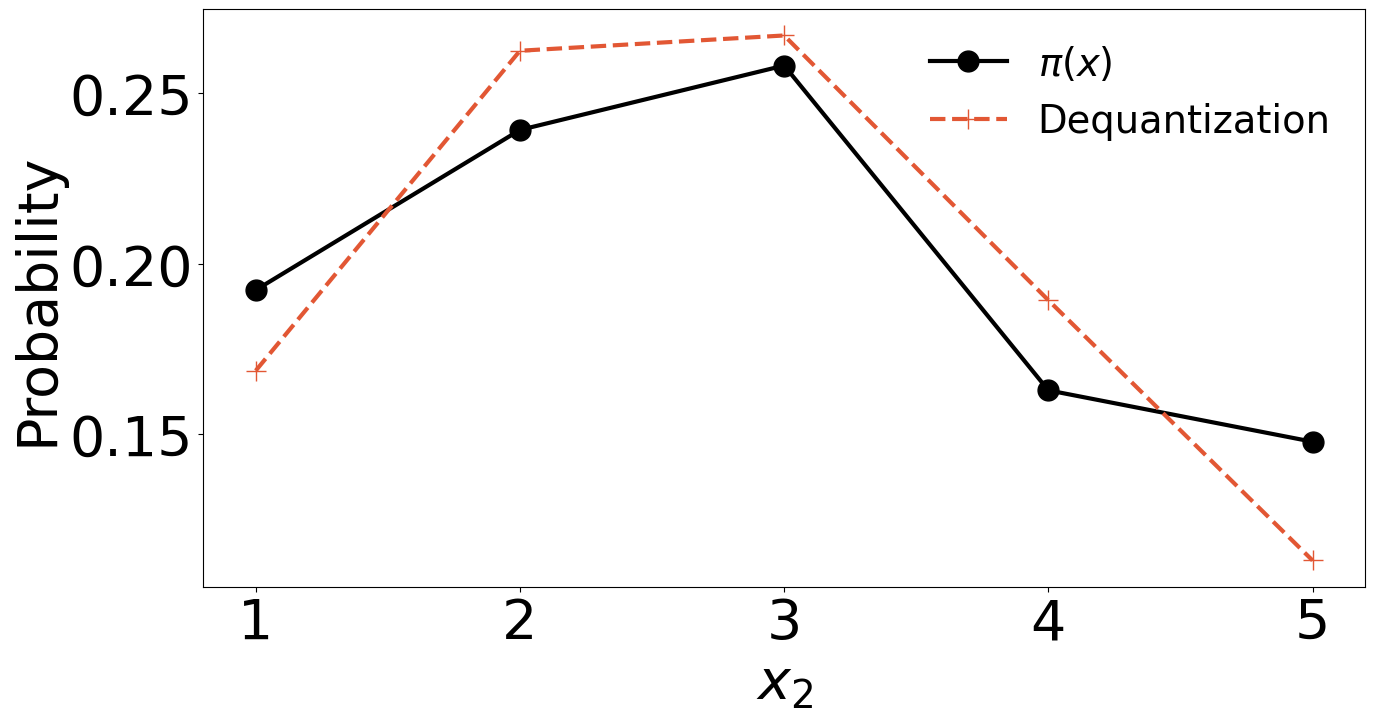

In [15]:
########################
########################
#   plot x2 results    #
########################
########################

ttx=np.arange(0,5)
plt.plot(ttx+0.5,np.sum(prbs_twodim,axis=0),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(dequant_density_twodim,axis=0),c='#E25734', label='Dequantization',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='x-small',frameon=False)
plt.xlabel(r'$x_2$')
plt.xticks(ticks=np.arange(0,5)+0.5,labels=np.arange(1,1+5))
plt.ylabel('Probability')

In [16]:
elbo_exact(np.log(dequant_density_twodim),np.log(prbs_twodim))

-0.18723490096046563

## 2D Mixture

In [60]:
########################
########################
# target specification #
########################
########################
mu=np.array([4,15]) # the two modes
K1,K2=20,2
def aux_gausslp(aux): return -0.5*(np.arange(0,20)-mu[aux][:,np.newaxis])**2-0.5*np.log(2*np.pi)
def aux_gausslp_1d(y,x): return -0.5*(y-mu[x])**2-0.5*np.log(2*np.pi)

def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs
    #
    # inputs:
    #    x    : (2,d) array with state values
    #    axis : int, full conditional to calculate; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,K_{axis+1}) array with d conditionals 
    
    y=x[0,:]
    aux=x[1,:]
    
    if axis==None: return -0.5*(y-mu[aux])**2-0.5*np.log(2*np.pi)
    if axis==0: return aux_gausslp(aux)
    if axis==1: 
        wlpy0=aux_gausslp_1d(y,0)+np.log(0.5)
        wlpy1=aux_gausslp_1d(y,1)+np.log(0.5)
        m=np.maximum(wlpy0,wlpy1)
        lpy=m+np.log(np.exp(wlpy0-m)+np.exp(wlpy1-m))
        out=np.ones((y.shape[0],2))
        out[:,0]=wlpy0
        out[:,1]=wlpy1
        return out-lpy[:,np.newaxis]
    raise Exception("Axis out of bounds - there aren't that many variables")

In [61]:
# evaluate target density
x=np.zeros((2,40),dtype=int)
x[0,:20]=np.arange(0,20)
x[0,20:]=np.arange(0,20)
x[1,20:]=np.ones(20,dtype=int)

mylp=np.exp(lp(x))
prbs=np.zeros((20,2))
prbs[:,0]=mylp[:20]
prbs[:,1]=mylp[20:]
prbs=prbs/np.sum(prbs)
prbs_mixture=np.copy(prbs)

In [64]:
########################
########################
#    Gibbs sampling    #
########################
########################
np.random.seed(2023)
gibbs_ss=5000
x0=np.array([15,1])

gibbs_samples_mixture=gibbs.gibbs_sampler(x0=x0,steps=gibbs_ss,lp=lp,burnin_pct=0.8,verbose=True)

In [65]:
########################
########################
#    dequantization    #
########################
########################

# settings
depth = 10
sample = np.copy(gibbs_samples_mixture)
width = 32
max_iters = 1001
lr = 1e-4

flow_mixture,loss_mixture=train_dequant_discrete(depth,sample,width,max_iters,lr)

iter 0: loss = 102.315
iter 100: loss = 11.914
iter 200: loss = 7.357
iter 300: loss = 5.668
iter 400: loss = 4.699
iter 500: loss = 4.140
iter 600: loss = 3.822
iter 700: loss = 3.456
iter 800: loss = 2.913
iter 900: loss = 2.531
iter 1000: loss = 2.258


In [67]:
dequant_samples = np.squeeze(flow_mixture.sample(10000).detach().numpy())
dequant_samples = np.floor(dequant_samples).astype(int) # round to get sample
dequant_density_mixture = plt.hist2d(dequant_samples[:,0],dequant_samples[:,1],density=True,
                         bins=[np.arange(0,K1+1),np.arange(0,K2+1)])[0]
plt.clf()

<Figure size 1500x750 with 0 Axes>

Text(0, 0.5, 'Probability')

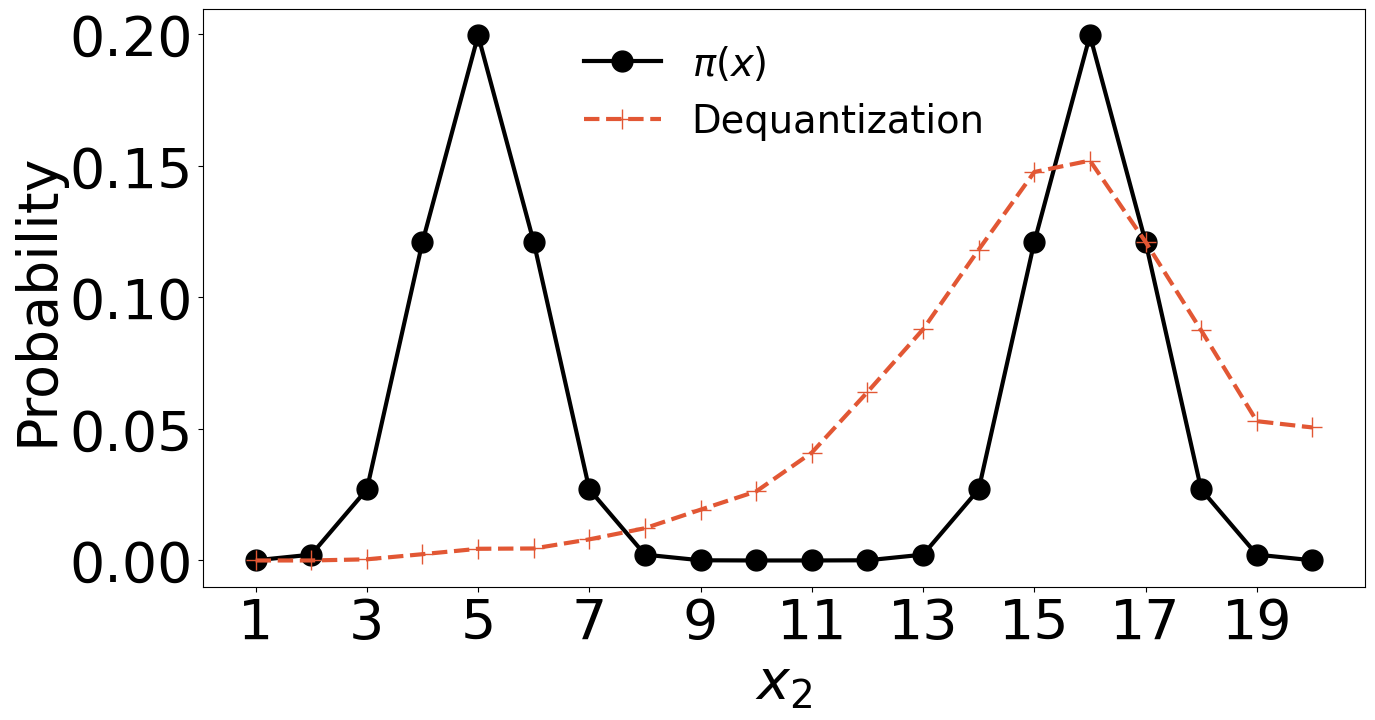

In [68]:
ttx=np.arange(0,20)
plt.plot(ttx+0.5,np.sum(prbs_mixture/np.sum(prbs_mixture),axis=1),c="black", label=r'$\pi(x)$',lw=3,ms=15,marker='o')
plt.plot(ttx+0.5,np.sum(dequant_density_mixture/np.sum(dequant_density_mixture),axis=1),
         c='#E25734', label='Dequantization',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='x-small',frameon=False)
plt.xlabel(r'$x_2$')
plt.xticks(ticks=np.arange(0,20,step=2)+0.5,labels=np.arange(1,21,step=2))
plt.ylabel('Probability')

## Ising $M$=5

In [17]:
########################
########################
# target specification #
########################
########################
M=5 # number of particles

# target
beta=1. # inverse temperature
logZ1=np.log(2*np.cosh(beta)) # same for any value of x_2 and x_(M-1)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs of the Ising model
    #
    # inputs:
    #    x    : (M,d) array with state values
    #    axis : int, variable to condition on; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,2) array with d conditionals 
    
    xc=np.copy(x)
    xc[xc==0]=-1 # internally lowest x=0, but here we need lowest x=-1
    if axis==None: 
        tmp_x=np.vstack((np.zeros((1,xc.shape[1])),np.copy(xc))) # add row with 0's at start of x
        lag_x=np.vstack((np.copy(xc),np.zeros((1,xc.shape[1])))) # add row with 0's at end of x
        return beta*np.sum(tmp_x*lag_x,axis=0)
    if axis==0: return np.vstack((-xc[1,:],xc[1,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis+1,:]))
    if axis==M-1: return np.vstack((-xc[-2,:],xc[-2,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis-1,:]))
    if axis>=M: raise Exception("Axis out of bounds")
    logZm=np.log(2*np.cosh(beta*(xc[axis-1,:]+xc[axis+1,:])))
    return np.vstack((-xc[axis-1,:]-xc[axis+1,:],xc[axis-1,:]+xc[axis+1,:])).T-logZm[:,np.newaxis]

In [18]:
x=concrete.idx_unflattenBinary(np.arange(0,2**M),M)
lprbs=lp(x)
prbs=np.exp(lprbs)
prbs=prbs/np.sum(prbs)
prbs_smallM=np.copy(prbs)
smallM=5

In [19]:
########################
########################
#    Gibbs sampling    #
########################
########################

np.random.seed(2023)
gibbs_ss=5000
x0=np.random.randint(low=0,high=2,size=M)

gibbs_samples_smallM=gibbs.gibbs_sampler(x0=x0,steps=gibbs_ss,lp=lp,burnin_pct=0.80,verbose=True)

In [20]:
########################
########################
#    dequantization    #
########################
########################

# settings
depth = 10
sample = np.copy(gibbs_samples_smallM)
width = 32
max_iters = 1001
lr = 1e-4

flow_gibbs,loss_gibbs=train_dequant_discrete(depth,sample,width,max_iters,lr)

iter 0: loss = 7.059
iter 100: loss = 4.473
iter 200: loss = 3.660
iter 300: loss = 3.393
iter 400: loss = 3.259
iter 500: loss = 3.173
iter 600: loss = 3.100
iter 700: loss = 3.035
iter 800: loss = 2.974
iter 900: loss = 2.917
iter 1000: loss = 2.871


In [21]:
dequant_samples = np.squeeze(flow_gibbs.sample(10000).detach().numpy())
dequant_samples = np.floor(dequant_samples).astype(int) # round to get sample
dequant_samples[dequant_samples<0]=0
dequant_samples[dequant_samples>1]=1
dequant_density_smallM = plt.hist(concrete.idx_flattenBinary(dequant_samples.T),
                                  bins=np.arange(0,2**M+1),density=True)[0]
plt.clf()

<Figure size 1500x750 with 0 Axes>

Text(0, 0.5, 'Probability')

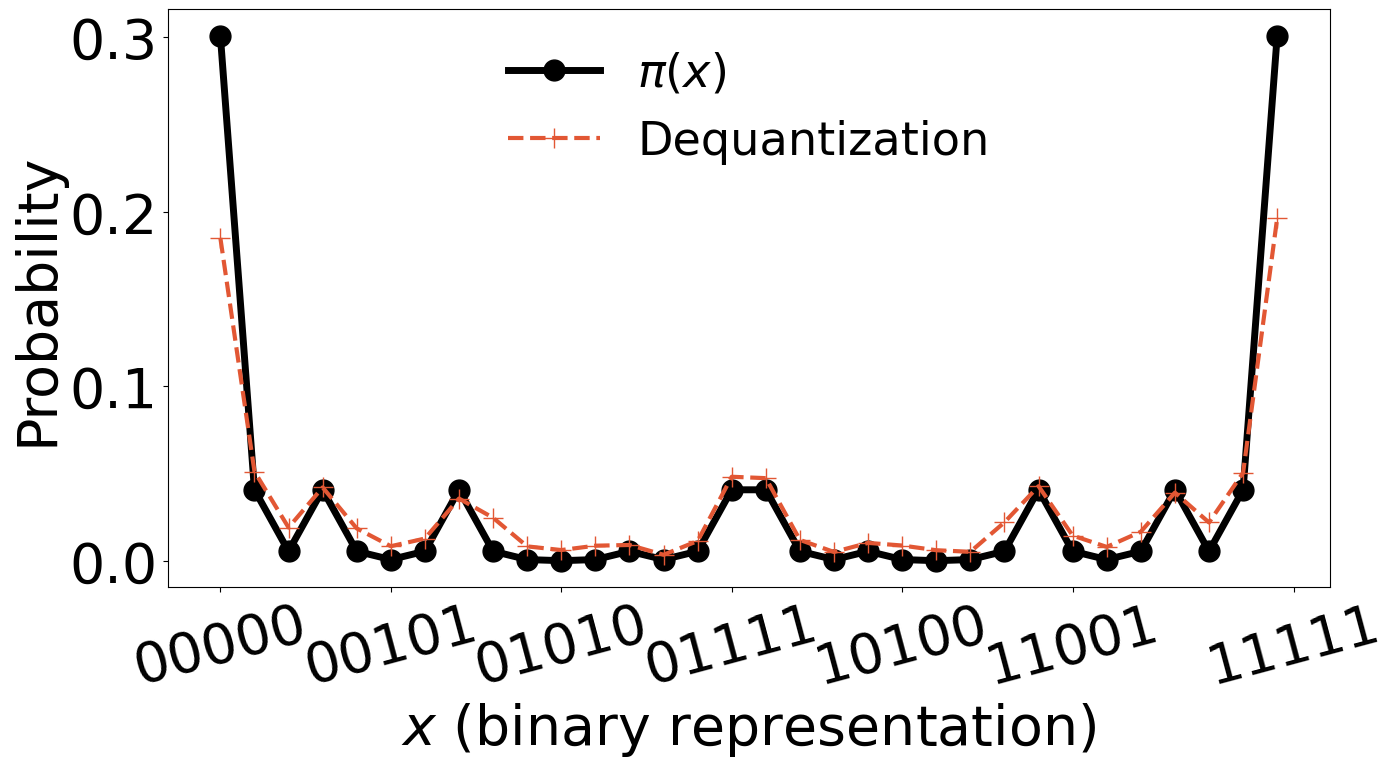

In [22]:
########################
########################
#     plot results     #
########################
########################
ticks=np.arange(0,2**smallM,step=smallM)+0.5
ticks[-1]=2**smallM

ttx=np.arange(0,2**smallM)
plt.plot(ttx+0.5,prbs_smallM,c="black", label=r'$\pi(x)$',lw=5,ms=15,marker='o')
plt.plot(ttx+0.5,dequant_density_smallM,c='#E25734', label='Dequantization',lw=3,ls='dashed',ms=15,marker='+')
plt.legend(fontsize='small',frameon=False)
plt.xlabel('$x$ (binary representation)')
plt.xticks(ticks=ticks,
           labels=[format(int(t), '05b') for t in ticks-0.5],
          rotation=15)
plt.ylabel('Probability')

## Ising $M$=50

In [23]:
########################
########################
# target specification #
########################
########################
M=50 # number of particles
largeM=50

# target
beta=5. # inverse temperature
logZ1=np.log(2*np.cosh(beta)) # same for any value of x_2 and x_(M-1)
def lp(x,axis=None):
    # compute the univariate log joint and conditional target pmfs of the Ising model
    #
    # inputs:
    #    x    : (M,d) array with state values
    #    axis : int, variable to condition on; returns joint if None
    # outputs:
    #   ext_lprb : if axis is None, (d,) array with log joint; else, (d,2) array with d conditionals 
    
    xc=np.copy(x)
    xc[xc==0]=-1 # internally lowest x=0, but here we need lowest x=-1
    if axis==None: 
        tmp_x=np.vstack((np.zeros((1,xc.shape[1])),np.copy(xc))) # add row with 0's at start of x
        lag_x=np.vstack((np.copy(xc),np.zeros((1,xc.shape[1])))) # add row with 0's at end of x
        return beta*np.sum(tmp_x*lag_x,axis=0)
    if axis==0: return np.vstack((-xc[1,:],xc[1,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis+1,:]))
    if axis==M-1: return np.vstack((-xc[-2,:],xc[-2,:])).T-logZ1#np.log(2*np.cosh(beta*xc[axis-1,:]))
    if axis>=M: raise Exception("Axis out of bounds")
    logZm=np.log(2*np.cosh(beta*(xc[axis-1,:]+xc[axis+1,:])))
    return np.vstack((-xc[axis-1,:]-xc[axis+1,:],xc[axis-1,:]+xc[axis+1,:])).T-logZm[:,np.newaxis]

In [25]:
########################
########################
#    Gibbs sampling    #
########################
########################

np.random.seed(2023)
gibbs_ss=5000
x0=np.random.randint(low=0,high=2,size=M)

gibbs_samples_largeM=gibbs.gibbs_sampler(x0=x0,steps=gibbs_ss,lp=lp,burnin_pct=0.80,verbose=True)

In [32]:
########################
########################
#    dequantization    #
########################
########################

# settings
depth = 10
sample = np.copy(gibbs_samples_largeM)
width = 32
max_iters = 1001
lr = 1e-4

flow_IsingLargeM,loss_IsingLargeM=train_dequant_discrete(depth,sample,width,max_iters,lr)

iter 0: loss = 88.367
iter 100: loss = 65.329
iter 200: loss = 50.504
iter 300: loss = 43.765
iter 400: loss = 41.774
iter 500: loss = 40.722
iter 600: loss = 39.640
iter 700: loss = 38.332
iter 800: loss = 37.016
iter 900: loss = 35.858
iter 1000: loss = 34.947


In [57]:
dequant_samples = np.squeeze(flow_IsingLargeM.sample(10000).detach().numpy())
dequant_samples = np.floor(dequant_samples).astype(int) # round to get sample
dequant_samples[dequant_samples<0]=0
dequant_samples[dequant_samples>1]=1

In [58]:
# estimate dequantization prbs
_,dequant_idx,dequant_counts=np.unique(dequant_samples,axis=0,return_index=True,return_counts=True)
dequant_prbs=np.zeros(10000)+1e-32
dequant_prbs[dequant_idx]=dequant_counts
dequant_prbs/=np.sum(dequant_prbs)
dequant_lp=np.log(dequant_prbs)

In [59]:
-np.mean(dequant_lp-lp(dequant_samples.T))

70.58434037197618

## GMM - Palmer penguins

In [69]:
from palmerpenguins import load_penguins
penguins = load_penguins().dropna()
std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data
K=3

/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_92536/2239819690.py:3: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data
/var/folders/k3/24b0dzl557v5m0_0658q2cxr0000gn/T/ipykernel_92536/2239819690.py:3: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_penguins=(penguins-penguins.mean())/penguins.std() # normalize data


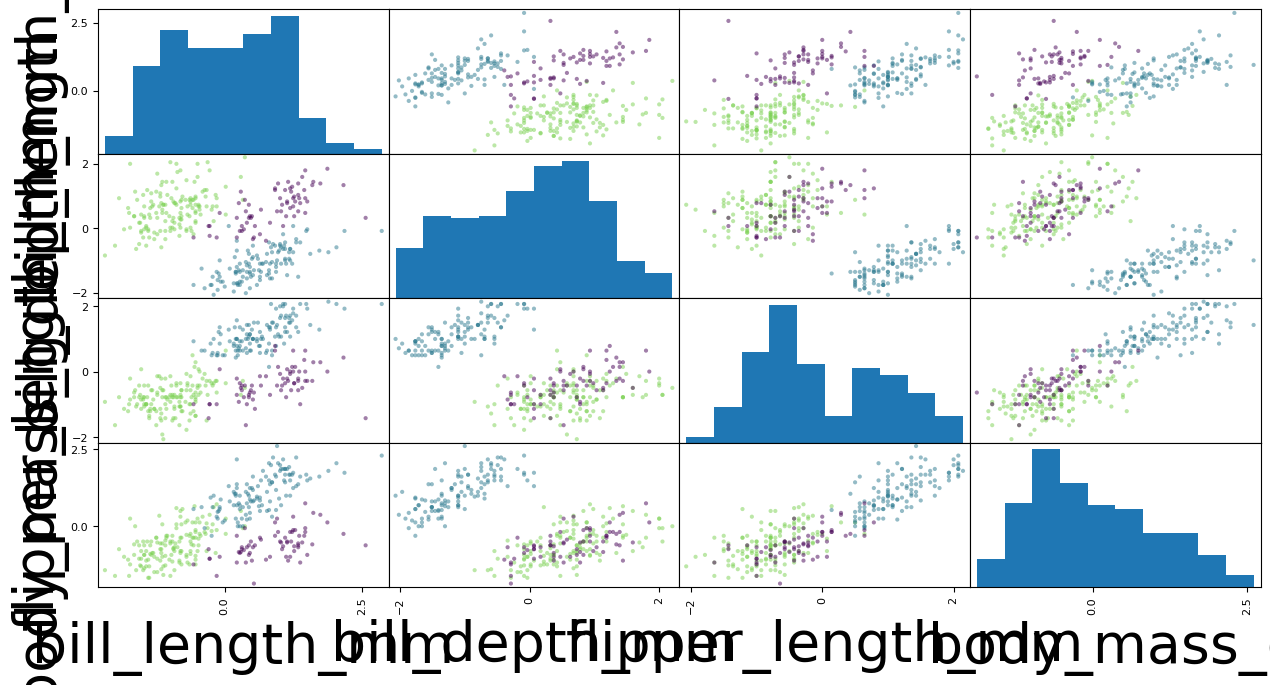

In [72]:
colors=np.squeeze(np.array(penguins[['species']]))
colors[colors=='Adelie']='#7ad151'
colors[colors=='Gentoo']='#2a788e'
colors[colors=='Chinstrap']='#440154'
pd.plotting.scatter_matrix(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=colors);

In [73]:
pg_dat=np.array(std_penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']])
pg_true=np.squeeze(np.array(penguins[['species']]))
pg_true[pg_true=='Adelie']=0
pg_true[pg_true=='Gentoo']=1
pg_true[pg_true=='Chinstrap']=2

In [77]:
####################
####################
#   Gibbs setup    #
####################
####################

# settings
steps=5000
burnin_pct=0.8
D=pg_dat.shape[1]

# initial arrays
#mu0=np.array([[35.,25.,175.,3500.],  # green
#              [55.,17.,200.,4000.],  # purple 
#              [45.,10.,225.,5000.]]) # blue
mu0=np.array([[-2.,1.,-1.,-1.],  # green
             [1.,1.,-0.5,-0.5],  # purple
             [1.,-1.5,1.5,2.]])  # blue
sigma0=np.zeros((K,D,D))
for k in range(K): sigma0[k,:,:]=0.5*np.eye(D)
w0=np.ones(K)/K

In [78]:
####################
####################
#   run sampler    #
####################
####################
seed=1

xs,ws,mus,sigmas=gibbs.gibbs_gmm(y=pg_dat,mu0=mu0,sigma0=sigma0,w0=w0,steps=steps,burnin_pct=burnin_pct,seed=seed)

In [237]:
from torch.distributions.distribution import Distribution
class GMMRef_dequant(Distribution):
    """
    Reference distribution for labels, weights, means, and covariances of a GMM.
    Gaussian for the (dequantized) labels,
    Dirichlet for the weights,
    Gaussians for the means,
    and InverseWishart for the covariances

    Inputs:
        N    : int, number of observations from the GMM
        K    : int, mixture size
        tau0 : float, labels and means prior precision
    """
    def __init__(self, N,K,D,tau0=1.):
        self.dirichlet = torch.distributions.dirichlet.Dirichlet(concentration=torch.ones(K))
        self.gauss  = torch.distributions.MultivariateNormal(torch.zeros(D), torch.eye(D)/np.sqrt(tau0))
        self.std_gauss = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
        self.invwis = torch.distributions.wishart.Wishart(df=N/K,covariance_matrix=torch.eye(D))
        self.K = K
        self.N = N
        self.D = D

    def log_prob(self, value):
        relcat_lp = torch.zeros(value.shape[0])
        for n in range(self.N): relcat_lp += self.std_gauss.log_prob(value[...,n])

        idx=np.diag_indices(self.D)
        xc=value[...,self.N:].T
        ws,mus,Hs=concrete.concrete_gmm_unflatten(xc,self.K,self.D) #(K,B),(K,D,B),(K,D,D,B)
        Sigmas=concrete.HtoSigma(Hs) #(K,D,D,B)
        xc_lp = torch.zeros(ws.shape[1])
        for k in range(self.K):
            xc_lp += self.invwis.log_prob(torch.moveaxis(Sigmas[k,...],2,0))
            xc_lp += self.D*torch.log(torch.tensor([2])) + torch.sum((self.D-torch.arange(self.D)+1)[:,None]*Hs[k,idx[0],idx[1],:],axis=0) # determinant Jacobian of log-Cholesky decomposition
            xc_lp += self.gauss.log_prob(mus[k,...].T)
        # end for
        return relcat_lp+xc_lp

    def sample(self,sample_shape=torch.Size()):
        labels_sample=self.std_gauss.sample(sample_shape)
        for n in range(self.N-1): labels_sample = torch.hstack((labels_sample,self.std_gauss.sample(sample_shape)))

        ws_sample = self.dirichlet.sample(sample_shape).T
        sigmas_sample = torch.zeros((self.K,self.D,self.D,sample_shape[0]))
        mus_sample = torch.zeros((self.K,self.D,sample_shape[0]))
        for k in range(self.K):
            sigmas_sample[k,...] = torch.moveaxis(self.invwis.sample(sample_shape),0,2)
            mus_sample[k,...] = self.gauss.sample(sample_shape).T
        # end for
        Hs_sample = concrete.SigmatoH(sigmas_sample)
        xc_sample = concrete.concrete_gmm_flatten(ws_sample,mus_sample,Hs_sample).T
        return torch.hstack((labels_sample,xc_sample))
#========================================

In [246]:
def create_dequant_gmm_RealNVP(depth,width,N,K,D,tau0):
    """
    Wrapper to init a RealNVP flow for a dequantization problem
    with dimension dim that consists of depth layers

    The reference distribution is an isotropic Gaussian

    Inputs:
        depth  : int, number of couplings (transformations)
        width  : int, width of the linear layers
        N      : int, number of observations from the GMM
        K      : int, mixture size
        D      : int, dimension of data
        tau0   : float, prior precision for means

    Outputs:
        flow   : Module, RealNVP
    """
    dim=int(N+K+K*D+K*(D+D*(D-1)/2))

    # create channel-wise masks of appropriate size
    masks=torch.zeros((2,dim))
    masks[0,:(dim//2)]=1
    masks[1,(dim-(dim//2)):]=1
    masks=masks.repeat(depth//2,1)

    # define reference distribution
    ref = GMMRef_dequant(N,K,D,tau0)

    # define scale and translation architectures
    net_s = lambda: nn.Sequential(
        nn.Linear(dim, width),
        nn.LeakyReLU(),
        nn.Linear(width, width),
        nn.LeakyReLU(),
        nn.Linear(width, dim),
        nn.Tanh()
    )
    net_t = lambda: nn.Sequential(
        nn.Linear(dim, width),
        nn.LeakyReLU(),
        nn.Linear(width, width),
        nn.LeakyReLU(),
        nn.Linear(width, dim)
    )
    return concrete.RealNVP(net_s, net_t, masks, ref, gmm=True)

In [247]:
def gmm_dequant_sample(pred_x,pred_w,pred_mus,pred_sigmas):
    """
    Generate sample for learning GMM with RealNVP
    dequantizing the labels

    Inputs:
        pred_x      : (steps,N) array, predicted label values (from `gibbs.gibbs_gmm`)
        pred_w      : (steps,K) array, predicted weights (from `gibbs.gibbs_gmm`)
        pred_mus    : (steps,K,D) array, predicted means (from `gibbs.gibbs_gmm`)
        pred_sigmas : (steps,K,D,D) array, predicted covariance matrices (from `gibbs.gibbs_gmm`)

    Outputs:
        dequant_sample : (steps,K'') array, samples to be used in training

    Note: K'' = N (labels) + K (weights) + KD (means) + Kx(D+DChoose2) (covariances, log-Cholesky decomposed)
    """
    # convert gibbs output to torch tensors
    xs     = torch.from_numpy(pred_x)
    ws     = torch.from_numpy(pred_w)
    mus    = torch.from_numpy(pred_mus)
    sigmas = torch.from_numpy(pred_sigmas)

    # dequantize label sample
    xd = xs + torch.rand(pred_x.shape)

    # deal with continuous variables
    Hs=concrete.SigmatoH(torch.moveaxis(sigmas,0,3))
    xc=concrete.concrete_gmm_flatten(ws.T,torch.moveaxis(mus,0,2),Hs).T

    # merge everything
    dequant_sample=torch.hstack((xd,xc)).float()

    return dequant_sample

In [248]:
def train_dequant_gmm(depth,N,K,D,tau0,sample,width=32,max_iters=1000,lr=1e-4,seed=0,verbose=True):
    """
    Train a RealNVP normalizing flow targeting a GMM with dequantized cluster labels

    Input:
        depth     : int, number of couplings (transformations)
        N         : int, number of observations from the GMM
        K         : int, mixture size
        D         : int, dimension of data
        tau0      : float, prior precision for means
        sample    : (B,K'') array, samples from target for training; B is the Monte Carlo sample size
        width     : int, width of the linear layers
        max_iters : int, max number of Adam iters
        lr        : float, Adam learning rate
        seed      : int, for reproducinility
        verbose   : boolean, indicating whether to print loss every 100 iterations of Adam

    Output:
        flow      : distribution, trained normalizing flow
        losses    : (maxiters,) array with loss traceplot

    Note: K'' = N (labels) + K (weights) + KD (means) + Kx(D+DChoose2) (covariances, which will be log-Cholesky decomposed)
    """
    torch.manual_seed(seed)

    # create flow
    flow=create_dequant_gmm_RealNVP(depth,width,N,K,D,tau0)

    # train flow
    optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr)
    losses=np.zeros(max_iters)

    for t in range(max_iters):
        loss = -flow.log_prob(sample).mean()
        losses[t]=loss

        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

        if verbose and t%(max_iters//10) == 0: print('iter %s:' % t, 'loss = %.3f' % loss)
    # end for
    return flow,losses

In [260]:
def dequant_gmm_unpack(x,N,K,D):
    """
    Unpack x=[xd,xc] into label normalized logprbs, weights, means, and covariances

    Inputs:
        x      : (B,K'') array, flattened values

    Outputs:
        xd     : (N,B) array, label log probabilities
        ws     : (K,B) array, weights
        mus    : (K,D,B) array, cluster means
        Sigmas : (K,D,D,B) array, cluster covariance matrices

    Note:
    K is the number of clusters, D is data dimension,
    and B is the number of data points (for vectorizing)
    K'' = N (labels) + K (weights) + KxD (means) + Kx(D+DChoose2) (covariances)

    Note:
    The label probabilities tensor will be converted to a np array and gradients will be detached
    """
    x=x.T
    B=x.shape[1]

    xd=x[:N,:].reshape(N,B)
    xd=xd.detach().numpy()
    
    xc=x[N:,:]
    ws,mus,Hs=concrete.concrete_gmm_unflatten(xc,K,D)
    Sigmas=concrete.HtoSigma(Hs)

    return xd,ws,mus,Sigmas
#========================================

In [249]:
########################
########################
#    dequantization    #
########################
########################

# settings
depth = 10
sample = gmm_dequant_sample(xs,ws,mus,sigmas)
width = 16
max_iters = 101
lr = 1e-4
tau0=1.

N,D=pg_dat.shape
K=3

flow_gmm_pg,loss_gmm_pg=train_dequant_gmm(
    depth,N,K,D,tau0,sample,width,max_iters,lr
)

iter 0: loss = 4380.926
iter 10: loss = 4055.538
iter 20: loss = 3819.560
iter 30: loss = 3542.464
iter 40: loss = 3205.543
iter 50: loss = 2941.822
iter 60: loss = 2689.063
iter 70: loss = 2481.807
iter 80: loss = 2266.383
iter 90: loss = 2007.061
iter 100: loss = 1835.901


In [253]:
pg_sample = flow_gmm_pg.sample(1000)

In [265]:
xd_pg,ws_pg,mus_pg,Sigmas_pg=dequant_gmm_unpack(pg_sample,N,K,D)

In [273]:
tt_xd = np.floor(xd_pg).astype(int)
tt_xd[tt_xd<0]=0
tt_xd[tt_xd>K]=K
pg_cols = np.mean(tt_xd,axis=1)

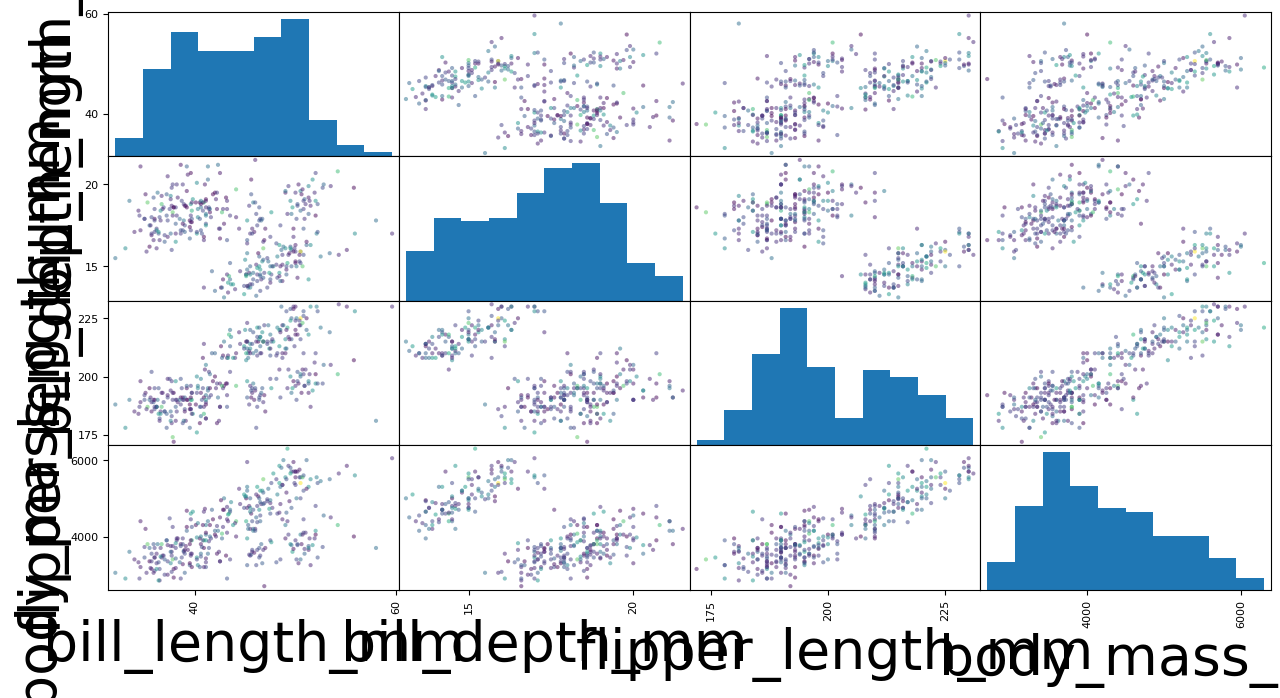

In [275]:
colors[pg_cols==0]='#440154'
colors[pg_cols==1]='#7ad151'
colors[pg_cols==2]='#2a788e'
pd.plotting.scatter_matrix(penguins[['bill_length_mm','bill_depth_mm','flipper_length_mm','body_mass_g']],c=pg_cols);

# Attempt 2

Taken from https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial11/NF_image_modeling.html

In [ ]:
## Standard libraries
import os
import math
import time
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "dat/dequantization_tutorial/"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "dat/dequantization_tutorial/"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

In [ ]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial11/"
# Files to download
pretrained_files = ["MNISTFlow_simple.ckpt", "MNISTFlow_vardeq.ckpt", "MNISTFlow_multiscale.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [ ]:
# Convert images from 0-1 to 0-255 (integers)
def discretize(sample):
    return (sample * 255).to(torch.int32)

# Transformations applied on each image => make them a tensor and discretize
transform = transforms.Compose([transforms.ToTensor(),
                                discretize])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=256, shuffle=False, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=False, drop_last=False, num_workers=4)

In [ ]:
def show_imgs(imgs, title=None, row_size=4):
    # Form a grid of pictures (we use max. 8 columns)
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    is_int = imgs.dtype==torch.int32 if isinstance(imgs, torch.Tensor) else imgs[0].dtype==torch.int32
    nrow = min(num_imgs, row_size)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128 if is_int else 0.5)
    np_imgs = imgs.cpu().numpy()
    # Plot the grid
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

show_imgs([train_set[i][0] for i in range(8)])

In [ ]:
train_set[0][0].shape

In [ ]:
class ImageFlow(pl.LightningModule):

    def __init__(self, flows, import_samples=8):
        """
        Inputs:
            flows - A list of flows (each a nn.Module) that should be applied on the images.
            import_samples - Number of importance samples to use during testing (see explanation below). Can be changed at any time
        """
        super().__init__()
        self.flows = nn.ModuleList(flows)
        self.import_samples = import_samples
        # Create prior distribution for final latent space
        self.prior = torch.distributions.normal.Normal(loc=0.0, scale=1.0)
        # Example input for visualizing the graph
        self.example_input_array = train_set[0][0].unsqueeze(dim=0)

    def forward(self, imgs):
        # The forward function is only used for visualizing the graph
        return self._get_likelihood(imgs)

    def encode(self, imgs):
        # Given a batch of images, return the latent representation z and ldj of the transformations
        z, ldj = imgs, torch.zeros(imgs.shape[0], device=self.device)
        for flow in self.flows:
            z, ldj = flow(z, ldj, reverse=False)
        return z, ldj

    def _get_likelihood(self, imgs, return_ll=False):
        """
        Given a batch of images, return the likelihood of those.
        If return_ll is True, this function returns the log likelihood of the input.
        Otherwise, the ouptut metric is bits per dimension (scaled negative log likelihood)
        """
        z, ldj = self.encode(imgs)
        log_pz = self.prior.log_prob(z).sum(dim=[1,2,3])
        log_px = ldj + log_pz
        nll = -log_px
        # Calculating bits per dimension
        bpd = nll * np.log2(np.exp(1)) / np.prod(imgs.shape[1:])
        return bpd.mean() if not return_ll else log_px

    @torch.no_grad()
    def sample(self, img_shape, z_init=None):
        """
        Sample a batch of images from the flow.
        """
        # Sample latent representation from prior
        if z_init is None:
            z = self.prior.sample(sample_shape=img_shape).to(device)
        else:
            z = z_init.to(device)

        # Transform z to x by inverting the flows
        ldj = torch.zeros(img_shape[0], device=device)
        for flow in reversed(self.flows):
            z, ldj = flow(z, ldj, reverse=True)
        return z

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # An scheduler is optional, but can help in flows to get the last bpd improvement
        scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        # Normalizing flows are trained by maximum likelihood => return bpd
        loss = self._get_likelihood(batch[0])
        self.log('train_bpd', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_likelihood(batch[0])
        self.log('val_bpd', loss)

    def test_step(self, batch, batch_idx):
        # Perform importance sampling during testing => estimate likelihood M times for each image
        samples = []
        for _ in range(self.import_samples):
            img_ll = self._get_likelihood(batch[0], return_ll=True)
            samples.append(img_ll)
        img_ll = torch.stack(samples, dim=-1)

        # To average the probabilities, we need to go from log-space to exp, and back to log.
        # Logsumexp provides us a stable implementation for this
        img_ll = torch.logsumexp(img_ll, dim=-1) - np.log(self.import_samples)

        # Calculate final bpd
        bpd = -img_ll * np.log2(np.exp(1)) / np.prod(batch[0].shape[1:])
        bpd = bpd.mean()

        self.log('test_bpd', bpd)

In [ ]:
class Dequantization(nn.Module):

    def __init__(self, alpha=1e-5, quants=256):
        """
        Inputs:
            alpha - small constant that is used to scale the original input.
                    Prevents dealing with values very close to 0 and 1 when inverting the sigmoid
            quants - Number of possible discrete values (usually 256 for 8-bit image)
        """
        super().__init__()
        self.alpha = alpha
        self.quants = quants

    def forward(self, z, ldj, reverse=False):
        if not reverse:
            z, ldj = self.dequant(z, ldj)
            z, ldj = self.sigmoid(z, ldj, reverse=True)
        else:
            z, ldj = self.sigmoid(z, ldj, reverse=False)
            z = z * self.quants
            ldj += np.log(self.quants) * np.prod(z.shape[1:])
            z = torch.floor(z).clamp(min=0, max=self.quants-1).to(torch.int32)
        return z, ldj

    def sigmoid(self, z, ldj, reverse=False):
        # Applies an invertible sigmoid transformation
        if not reverse:
            ldj += (-z-2*F.softplus(-z)).sum(dim=[1,2,3])
            z = torch.sigmoid(z)
            # Reversing scaling for numerical stability
            ldj -= np.log(1 - self.alpha) * np.prod(z.shape[1:])
            z = (z - 0.5 * self.alpha) / (1 - self.alpha)
        else:
            z = z * (1 - self.alpha) + 0.5 * self.alpha  # Scale to prevent boundaries 0 and 1
            ldj += np.log(1 - self.alpha) * np.prod(z.shape[1:])
            ldj += (-torch.log(z) - torch.log(1-z)).sum(dim=[1,2,3])
            z = torch.log(z) - torch.log(1-z)
        return z, ldj

    def dequant(self, z, ldj):
        # Transform discrete values to continuous volumes
        z = z.to(torch.float32)
        z = z + torch.rand_like(z).detach()
        z = z / self.quants
        ldj -= np.log(self.quants) * np.prod(z.shape[1:])
        return z, ldj

In [ ]:
## Testing invertibility of dequantization layer
pl.seed_everything(42)
orig_img = train_set[0][0].unsqueeze(dim=0)
ldj = torch.zeros(1,)
dequant_module = Dequantization()
deq_img, ldj = dequant_module(orig_img, ldj, reverse=False)
reconst_img, ldj = dequant_module(deq_img, ldj, reverse=True)

d1, d2 = torch.where(orig_img.squeeze() != reconst_img.squeeze())
if len(d1) != 0:
    print("Dequantization was not invertible.")
    for i in range(d1.shape[0]):
        print("Original value:", orig_img[0,0,d1[i], d2[i]].item())
        print("Reconstructed value:", reconst_img[0,0,d1[i], d2[i]].item())
else:
    print("Successfully inverted dequantization")

# Layer is not strictly invertible due to float precision constraints
# assert (orig_img == reconst_img).all().item()

In [ ]:
def visualize_dequantization(quants, prior=None):
    """
    Function for visualizing the dequantization values of discrete values in continuous space
    """
    # Prior over discrete values. If not given, a uniform is assumed
    if prior is None:
        prior = np.ones(quants, dtype=np.float32) / quants
    prior = prior / prior.sum()  # Ensure proper categorical distribution

    inp = torch.arange(-4, 4, 0.01).view(-1, 1, 1, 1) # Possible continuous values we want to consider
    ldj = torch.zeros(inp.shape[0])
    dequant_module = Dequantization(quants=quants)
    # Invert dequantization on continuous values to find corresponding discrete value
    out, ldj = dequant_module.forward(inp, ldj, reverse=True)
    inp, out, prob = inp.squeeze().numpy(), out.squeeze().numpy(), ldj.exp().numpy()
    prob = prob * prior[out] # Probability scaled by categorical prior

    # Plot volumes and continuous distribution
    sns.set_style("white")
    fig = plt.figure(figsize=(6,3))
    x_ticks = []
    for v in np.unique(out):
        indices = np.where(out==v)
        color = to_rgb(f"C{v}")
        plt.fill_between(inp[indices], prob[indices], np.zeros(indices[0].shape[0]), color=color+(0.5,), label=str(v))
        plt.plot([inp[indices[0][0]]]*2,  [0, prob[indices[0][0]]],  color=color)
        plt.plot([inp[indices[0][-1]]]*2, [0, prob[indices[0][-1]]], color=color)
        x_ticks.append(inp[indices[0][0]])
    x_ticks.append(inp.max())
    plt.xticks(x_ticks, [f"{x:.1f}" for x in x_ticks])
    plt.plot(inp,prob, color=(0.0,0.0,0.0))
    # Set final plot properties
    plt.ylim(0, prob.max()*1.1)
    plt.xlim(inp.min(), inp.max())
    plt.xlabel("z")
    plt.ylabel("Probability")
    plt.title(f"Dequantization distribution for {quants} discrete values")
    plt.legend()
    plt.show()
    plt.close()

visualize_dequantization(quants=8)

In [ ]:
visualize_dequantization(quants=8, prior=np.array([0.075, 0.2, 0.4, 0.2, 0.075, 0.025, 0.0125, 0.0125]))

In [ ]:
class VariationalDequantization(Dequantization):

    def __init__(self, var_flows, alpha=1e-5):
        """
        Inputs:
            var_flows - A list of flow transformations to use for modeling q(u|x)
            alpha - Small constant, see Dequantization for details
        """
        super().__init__(alpha=alpha)
        self.flows = nn.ModuleList(var_flows)

    def dequant(self, z, ldj):
        z = z.to(torch.float32)
        #img = (z / 255.0) * 2 - 1 # We condition the flows on x, i.e. the original image
        img = z.clone()

        # Prior of u is a uniform distribution as before
        # As most flow transformations are defined on [-infinity,+infinity], we apply an inverse sigmoid first.
        deq_noise = torch.rand_like(z).detach()
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=True)
        for flow in self.flows:
            deq_noise, ldj = flow(deq_noise, ldj, reverse=False, orig_img=img)
        deq_noise, ldj = self.sigmoid(deq_noise, ldj, reverse=False)

        # After the flows, apply u as in standard dequantization
        z = (z + deq_noise) #/ 256.0
        #ldj -= np.log(256.0) * np.prod(z.shape[1:])
        return z, ldj

In [ ]:
class CouplingLayer(nn.Module):

    def __init__(self, network, mask, c_in):
        """
        Coupling layer inside a normalizing flow.
        Inputs:
            network - A PyTorch nn.Module constituting the deep neural network for mu and sigma.
                      Output shape should be twice the channel size as the input.
            mask - Binary mask (0 or 1) where 0 denotes that the element should be transformed,
                   while 1 means the latent will be used as input to the NN.
            c_in - Number of input channels
        """
        super().__init__()
        self.network = network
        self.scaling_factor = nn.Parameter(torch.zeros(c_in))
        # Register mask as buffer as it is a tensor which is not a parameter,
        # but should be part of the modules state.
        self.register_buffer('mask', mask)

    def forward(self, z, ldj, reverse=False, orig_img=None):
        """
        Inputs:
            z - Latent input to the flow
            ldj - The current ldj of the previous flows.
                  The ldj of this layer will be added to this tensor.
            reverse - If True, we apply the inverse of the layer.
            orig_img (optional) - Only needed in VarDeq. Allows external
                                  input to condition the flow on (e.g. original image)
        """
        # Apply network to masked input
        z_in = z * self.mask
        if orig_img is None:
            nn_out = self.network(z_in)
        else:
            nn_out = self.network(torch.cat([z_in, orig_img], dim=1))
        s, t = nn_out.chunk(2, dim=1)

        # Stabilize scaling output
        s_fac = self.scaling_factor.exp().view(1, -1, 1, 1)
        s = torch.tanh(s / s_fac) * s_fac

        # Mask outputs (only transform the second part)
        s = s * (1 - self.mask)
        t = t * (1 - self.mask)

        # Affine transformation
        if not reverse:
            # Whether we first shift and then scale, or the other way round,
            # is a design choice, and usually does not have a big impact
            z = (z + t) * torch.exp(s)
            ldj += s.sum(dim=[1,2,3])
        else:
            z = (z * torch.exp(-s)) - t
            ldj -= s.sum(dim=[1,2,3])

        return z, ldj

In [ ]:
with torch.no_grad():
    x = torch.arange(-5,5,0.01)
    scaling_factors = [0.5, 1, 2]
    sns.set()
    fig, ax = plt.subplots(1, 3, figsize=(12,3))
    for i, scale in enumerate(scaling_factors):
        y = torch.tanh(x / scale) * scale
        ax[i].plot(x.numpy(), y.numpy())
        ax[i].set_title("Scaling factor: " + str(scale))
        ax[i].set_ylim(-3, 3)
    plt.subplots_adjust(wspace=0.4)
    sns.reset_orig()
    plt.show()

In [ ]:
def create_checkerboard_mask(h, w, invert=False):
    x, y = torch.arange(h, dtype=torch.int32), torch.arange(w, dtype=torch.int32)
    xx, yy = torch.meshgrid(x, y, indexing='ij')
    mask = torch.fmod(xx + yy, 2)
    mask = mask.to(torch.float32).view(1, 1, h, w)
    if invert:
        mask = 1 - mask
    return mask

def create_channel_mask(c_in, invert=False):
    mask = torch.cat([torch.ones(c_in//2, dtype=torch.float32),
                      torch.zeros(c_in-c_in//2, dtype=torch.float32)])
    mask = mask.view(1, c_in, 1, 1)
    if invert:
        mask = 1 - mask
    return mask

In [ ]:
checkerboard_mask = create_checkerboard_mask(h=8, w=8).expand(-1,2,-1,-1)
channel_mask = create_channel_mask(c_in=2).expand(-1,-1,8,8)

show_imgs(checkerboard_mask.transpose(0,1), "Checkerboard mask")
show_imgs(channel_mask.transpose(0,1), "Channel mask")

In [ ]:
class ConcatELU(nn.Module):
    """
    Activation function that applies ELU in both direction (inverted and plain).
    Allows non-linearity while providing strong gradients for any input (important for final convolution)
    """

    def forward(self, x):
        return torch.cat([F.elu(x), F.elu(-x)], dim=1)


class LayerNormChannels(nn.Module):

    def __init__(self, c_in, eps=1e-5):
        """
        This module applies layer norm across channels in an image.
        Inputs:
            c_in - Number of channels of the input
            eps - Small constant to stabilize std
        """
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(1, c_in, 1, 1))
        self.beta = nn.Parameter(torch.zeros(1, c_in, 1, 1))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = x.var(dim=1, unbiased=False, keepdim=True)
        y = (x - mean) / torch.sqrt(var + self.eps)
        y = y * self.gamma + self.beta
        return y


class GatedConv(nn.Module):

    def __init__(self, c_in, c_hidden):
        """
        This module applies a two-layer convolutional ResNet block with input gate
        Inputs:
            c_in - Number of channels of the input
            c_hidden - Number of hidden dimensions we want to model (usually similar to c_in)
        """
        super().__init__()
        self.net = nn.Sequential(
            ConcatELU(),
            nn.Conv2d(2*c_in, c_hidden, kernel_size=3, padding=1),
            ConcatELU(),
            nn.Conv2d(2*c_hidden, 2*c_in, kernel_size=1)
        )

    def forward(self, x):
        out = self.net(x)
        val, gate = out.chunk(2, dim=1)
        return x + val * torch.sigmoid(gate)


class GatedConvNet(nn.Module):

    def __init__(self, c_in, c_hidden=32, c_out=-1, num_layers=3):
        """
        Module that summarizes the previous blocks to a full convolutional neural network.
        Inputs:
            c_in - Number of input channels
            c_hidden - Number of hidden dimensions to use within the network
            c_out - Number of output channels. If -1, 2 times the input channels are used (affine coupling)
            num_layers - Number of gated ResNet blocks to apply
        """
        super().__init__()
        c_out = c_out if c_out > 0 else 2 * c_in
        layers = []
        layers += [nn.Conv2d(c_in, c_hidden, kernel_size=3, padding=1)]
        for layer_index in range(num_layers):
            layers += [GatedConv(c_hidden, c_hidden),
                       LayerNormChannels(c_hidden)]
        layers += [ConcatELU(),
                   nn.Conv2d(2*c_hidden, c_out, kernel_size=3, padding=1)]
        self.nn = nn.Sequential(*layers)

        self.nn[-1].weight.data.zero_()
        self.nn[-1].bias.data.zero_()

    def forward(self, x):
        return self.nn(x)

In [ ]:
def create_simple_flow(use_vardeq=True):
    flow_layers = []
    if use_vardeq:
        vardeq_layers = [CouplingLayer(network=GatedConvNet(c_in=2, c_out=2, c_hidden=16),
                                       mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                       c_in=1) for i in range(4)]
        flow_layers += [VariationalDequantization(var_flows=vardeq_layers)]
    else:
        flow_layers += [Dequantization()]

    for i in range(8):
        flow_layers += [CouplingLayer(network=GatedConvNet(c_in=1, c_hidden=32),
                                      mask=create_checkerboard_mask(h=28, w=28, invert=(i%2==1)),
                                      c_in=1)]

    flow_model = ImageFlow(flow_layers).to(device)
    return flow_model

In [ ]:
def train_flow(flow, model_name="MNISTFlow"):
    # Create a PyTorch Lightning trainer
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, model_name),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=200,
                         gradient_clip_val=1.0,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd"),
                                    LearningRateMonitor("epoch")],
                         check_val_every_n_epoch=5)
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    train_data_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=8)
    result = None

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, model_name + ".ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        ckpt = torch.load(pretrained_filename, map_location=device)
        flow.load_state_dict(ckpt['state_dict'], strict=False)
        result = ckpt.get("result", None)
    else:
        print("Start training", model_name)
        trainer.fit(flow, train_data_loader, val_loader)

    # Test best model on validation and test set if no result has been found
    # Testing can be expensive due to the importance sampling.
    if result is None:
        val_result = trainer.test(flow, val_loader, verbose=False)
        start_time = time.time()
        test_result = trainer.test(flow, test_loader, verbose=False)
        duration = time.time() - start_time
        result = {"test": test_result, "val": val_result, "time": duration / len(test_loader) / flow.import_samples}

    return flow, result

In [ ]:
flow_dict = {"simple": {}, "vardeq": {}, "multiscale": {}}
flow_dict["simple"]["model"], flow_dict["simple"]["result"] = train_flow(create_simple_flow(use_vardeq=False), model_name="MNISTFlow_simple")
flow_dict["vardeq"]["model"], flow_dict["vardeq"]["result"] = train_flow(create_simple_flow(use_vardeq=True), model_name="MNISTFlow_vardeq")

In [ ]:
flow_dict["simple"]["result"]

In [ ]:
pl.seed_everything(44)
samples = flow_dict["simple"]["model"].sample(img_shape=[16,1,28,28])
show_imgs(samples.cpu())

In [ ]:
def visualize_dequant_distribution(model : ImageFlow, imgs : torch.Tensor, title:str=None):
    """
    Inputs:
        model - The flow of which we want to visualize the dequantization distribution
        imgs - Example training images of which we want to visualize the dequantization distribution
    """
    imgs = imgs.to(device)
    ldj = torch.zeros(imgs.shape[0], dtype=torch.float32).to(device)
    with torch.no_grad():
        dequant_vals = []
        for _ in tqdm(range(8), leave=False):
            d, _ = model.flows[0](imgs, ldj, reverse=False)
            dequant_vals.append(d)
        dequant_vals = torch.cat(dequant_vals, dim=0)
    dequant_vals = dequant_vals.view(-1).cpu().numpy()
    sns.set()
    plt.figure(figsize=(10,3))
    plt.hist(dequant_vals, bins=256, color=to_rgb("C0")+(0.5,), edgecolor="C0", density=True)
    if title is not None:
        plt.title(title)
    plt.show()
    plt.close()

sample_imgs, _ = next(iter(train_loader))

In [ ]:
visualize_dequant_distribution(flow_dict["simple"]["model"], sample_imgs, title="Dequantization")

In [ ]:
visualize_dequant_distribution(flow_dict["vardeq"]["model"], sample_imgs, title="Variational dequantization")